# Simple 2D Bayesian Optimisation over smb for the East Antarctic Plateau

This notebook is created to showcase a simple application of Bayesian Optimisation (BO) to surface mass balance data.

Objective: 
Find location with minimum smb (39-year-average) over the East Antarctic Plateau. 

## Data

- RACMO2.3p3 ANT27 data
    - key publication [van Dalum et al. 2022](10.5194/egusphere-egu22-12543)
    - data on zenodo [link](https://zenodo.org/record/5512077#.Y-BERuxBwvo), CON stands for Control run
        - file: `smb_monthlyS_ANT27_CONsettings_197901_201812.nc`
    - overview of model versions and meta data on [Institute for Marine and Atmospheric research Utrecht (IMAU) website](https://www.projects.science.uu.nl/iceclimate/models/racmo-data.php)
    - description of model updates on [website](https://www.projects.science.uu.nl/iceclimate/models/racmo-model.php#1-2)
        
- Previous version: RACMO2.3p2 ANT27 data 
     - data on [Utrecht University server](https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/)
     - I requested 2 km downscaled smb data from RACMO2.3p2 (stereographic projection) from [Dr Brice Noël](https://scholar.google.be/citations?user=MnrZh5wAAAAJ&hl=en)

### Units
Surface Mass Balance (SMB) in units of millimeters of water equivalent (w.e.) per year. The unit is the same as kg m^(–2). 

### Projection
- The smb data is provided using Rotated Pole projection. 
- I am using [EPSG:3031](https://epsg.io/3031) WGS 84 / Antarctic Polar Stereographic projection because this is one of the two standards for Antarctic data.

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.colors as colors

# cartopy: Coordinate Reference System (list of projections)
import cartopy
# common abbreviation
import cartopy.crs as ccrs
import cartopy.feature as cfe

# Projections between CRSs (Coordinate Reference Systems)
import pyproj
import shapely
from pyproj import Proj, transform

import gpytorch
import torch
import GPy 

from botorch.models import SingleTaskGP, ModelListGP
# Gpytorch is a dependency of BoTorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

# Inline interactive vis properties in Jupyter lab
%matplotlib ipympl
%matplotlib inline

import watermark

/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load data

In [3]:
# change this to your path
full_path = "/Users/kimbente/Desktop/Bayesian Optimisation/BO-ANT-project/raw-data/RACMO2.3p3/CON_data/smb_monthlyS_ANT27_CONsettings_197901_201812.nc"

ds = xr.open_dataset(full_path)

## Preprocess

In [4]:
# PREPROCESSING IN XARRAY
def preprocess_racmo_xr(dataset_xr):
    """
    """
    # remove height as dimension and as coordinate because it is redundant
    dataset_xr_clean = dataset_xr.drop_vars('height').squeeze()
    # extract smb variable and take mean over all available years
    # type needs to be xarray.Dataset to have explicit dimensions
    dataset_smb_xr = dataset_xr_clean["smb"].mean("time").to_dataset()
    
    # PROJECTION
    # define projection from rotated pole to APS
    # always x y or lon lat order
    rotatedpole_to_APS71_func = pyproj.Transformer.from_crs(crs_from = pyproj.CRS("-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-180.0 +lon_0=10.0"),  
                                                  crs_to = pyproj.CRS("+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"), 
                                                  always_xy = True)
    # create meshgrid from rotated_pole grid
    rlon_2d, rlat_2d = np.meshgrid(dataset_smb_xr.rlon.values, dataset_smb_xr.rlat.values)
    # transform points
    x_2d, y_2d = rotatedpole_to_APS71_func.transform(rlon_2d, rlat_2d)
    # add as coordinates to to xarray
    dataset_smb_xr.coords['x_2d'] = (dataset_smb_xr.coords["lat"].dims, x_2d)
    dataset_smb_xr.coords['y_2d'] = (dataset_smb_xr.coords["lon"].dims, y_2d)
    
    return dataset_smb_xr

# call xarray preprocessing function
ds_xr_processed = preprocess_racmo_xr(ds)

In [5]:
# CREATE DATAFRAME
# extract flattend pairs of xy coordinates
xy_pairs = np.array([ds_xr_processed.coords['x_2d'].values, ds_xr_processed.coords['y_2d'].values]).reshape(2,-1)

# create pandas DataFrame
df = pd.DataFrame(data = {'smb': ds_xr_processed.smb.values.reshape(-1),
                          # first column
                          'x': xy_pairs[0,:],
                          # second column
                          'y': xy_pairs[1,:],
                                        }
                                )

In [6]:
# Subset region to square in the East Antarctic Plateau
# min and max in APS projection
x_min = 600000
x_max = 1900000

y_min = -1000000
y_max = 300000

df_EAIS = df[df['x'].between(x_min, x_max) & df['y'].between(y_min, y_max)]

In [7]:
# Show area
def plot_APS(dataset, dataset_values):
    """
    """
    plt.figure(figsize = (5, 5))
    
    # Projection: target map; north is aligned with Greenwich (longitude), centred at South Pole
    ax = plt.subplot(projection = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.))
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    # set up a Cartopy coordinate reference system for the data (rotated pole as described above)
    data_crs = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.)

    # Overlay of black coastline (built-in)
    ax.coastlines(resolution = '50m')

    # Add dots of data grid
    ax.scatter(x = x_min, y = y_min, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_min, y = y_max, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_max, y = y_min, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_max, y = y_max, c = "red", marker = "+", transform = data_crs)

    # softcoded
    ax.set_title("Selected area")

    plt.show()

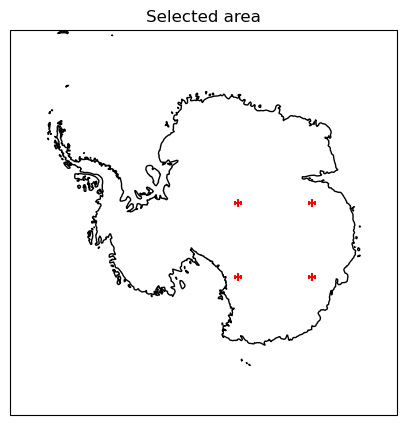

In [8]:
plot_APS(None, None)

# GP over smb

Since this is a simulated experiment, we assume access to the true smb function, based on data from the RACMO2.3p3 regional climate model (RCM). The data is provided on a grid, based on the rotated pole projection. We will be using the Antarctic Polar Stereographic projection (APS) for visualisations and in a subsequent problem setting with additional input data, since this is the dominant projection used in Antarctic Science. More information about APS can be read on [NSIDC webiste](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection).

To optimise in the continous domain - where we can query anywhere - we use a GP to interpolate/infer a continous, smooth target function. For now, we treat this function as noise-less ground truth.

Because we are using the BoTorch package for Bayeisan Optimisation, we will use GPyTorch for Gaussian Processes. (see [GPyTorch’s documentation](https://docs.gpytorch.ai/en/stable/index.html))

### Prepare data for torch

In [9]:
# Normalise input coordinates with bounds of selected area
x1_norm = (df_EAIS.x.values - x_min)/(x_max - x_min)
x2_norm = (df_EAIS.y.values - y_min)/(y_max - y_min)

# transpose for shape: torch.Size([2238, 2])
train_x = torch.tensor(np.array([x1_norm, x2_norm]).T, dtype = torch.double)
train_y = torch.tensor(np.array(df_EAIS["smb"]), dtype = torch.double)

# TEST: equally spaced grid
x1_mesh, x2_mesh = np.meshgrid(np.linspace(0, 1, 51), np.linspace(0, 1, 51))
test_x = torch.tensor(np.array([x1_mesh.reshape(-1), x2_mesh.reshape(-1)]).T, dtype = torch.double)

### Initialise model and likelihood

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Try other kernels
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5))
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 80

# Train mode: Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood, exact inference
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    # Negative marginal log likelihood
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - NMLL Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/80 - NMLL Loss: 0.888   lengthscale: 0.693   noise: 0.693
Iter 2/80 - NMLL Loss: 0.797   lengthscale: 0.598   noise: 0.598
Iter 3/80 - NMLL Loss: 0.708   lengthscale: 0.514   noise: 0.513
Iter 4/80 - NMLL Loss: 0.621   lengthscale: 0.441   noise: 0.437
Iter 5/80 - NMLL Loss: 0.536   lengthscale: 0.381   noise: 0.371
Iter 6/80 - NMLL Loss: 0.455   lengthscale: 0.335   noise: 0.312
Iter 7/80 - NMLL Loss: 0.375   lengthscale: 0.305   noise: 0.262
Iter 8/80 - NMLL Loss: 0.294   lengthscale: 0.290   noise: 0.219
Iter 9/80 - NMLL Loss: 0.211   lengthscale: 0.288   noise: 0.182
Iter 10/80 - NMLL Loss: 0.125   lengthscale: 0.297   noise: 0.151
Iter 11/80 - NMLL Loss: 0.038   lengthscale: 0.314   noise: 0.125
Iter 12/80 - NMLL Loss: -0.050   lengthscale: 0.339   noise: 0.103
Iter 13/80 - NMLL Loss: -0.138   lengthscale: 0.370   noise: 0.085
Iter 14/80 - NMLL Loss: -0.224   lengthscale: 0.406   noise: 0.070
Iter 15/80 - NMLL Loss: -0.308   lengthscale: 0.443   noise: 0.057
Iter 16/80 - NM

Observations: Lengthscale parameter gets reduced to for more local inference.|

Trying other kernels. However GridKernel require input data to be on regular kernel. Due to projection into APS, the input data is not on a regular grid

In [12]:
# Ensure eval mode
model.eval()
likelihood.eval()

# Slice
# Small test for x1 == 0. Where first column (x1 = 0)
test_x_x0 = test_x[np.where(test_x[:,0] == 0.)]

f_preds_x0 = model(test_x_x0)
y_preds_x0 = likelihood(model(test_x_x0))

# Unpacking the predictions
f_mean_x0 = f_preds_x0.mean
f_var_x0 = f_preds_x0.variance
f_covar_x0 = f_preds_x0.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(100,))

# 2D visualisation

We are slicing through the 3D surface at x = 0 to visualise the GP regression.

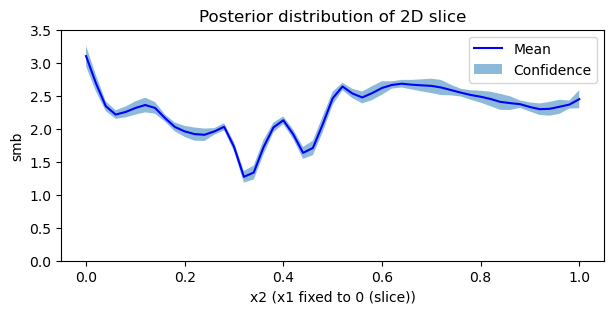

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize = (7, 3))

    # Get upper and lower confidence bounds
    lower, upper = y_preds_x0.confidence_region()
    
    # Plot predictive means as blue line
    # test_x_x0 is 2D so select second column only
    ax.plot(test_x_x0[:,1].numpy(), y_preds_x0.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_x0[:,1].numpy(), lower.numpy(), upper.numpy(), alpha = 0.5)
    
    # observations are on different grid but just add 22 obs very close to x = 0 line
    # ax.plot(((df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["y"].values - y_min)/(y_max - y_min)), 
    #        df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["smb"].values, 'k*')
    
    ax.set_ylim([0, 3.5])
    ax.legend(['Mean', 'Confidence'])
    
    ax.set_title("Posterior distribution of 2D slice")
    ax.set_xlabel('x2 (x1 fixed to 0 (slice))')
    ax.set_ylabel('smb')
    
    # add additional datapoints from model

# Interpolate at smooth grid

In [14]:
# Ensure eval mode
model.eval()
likelihood.eval()

# Multivariate normal
f_preds = model(test_x)
# mean values
y_preds = likelihood(model(test_x))

# Unpacking the predictions
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

# 3D visualisation

In [15]:
df_smb_grid = pd.DataFrame(data = {'smb_mean': f_mean.detach().numpy(), 
                     'smb_var': f_var.detach().numpy(), 
                     'x1_norm': test_x[:,0].numpy(),
                     'x2_norm': test_x[:,1].numpy(),
                    })

# x1 need to be the columns (x-axis) (order!)
df_x1x2_matrix = df_smb_grid.pivot(index = 'x2_norm', columns = 'x1_norm', values = 'smb_mean')
x1_mesh, x2_mesh = np.meshgrid(df_x1x2_matrix.columns, df_x1x2_matrix.index)
# columns are the x1's
y_mesh = np.array(df_x1x2_matrix)

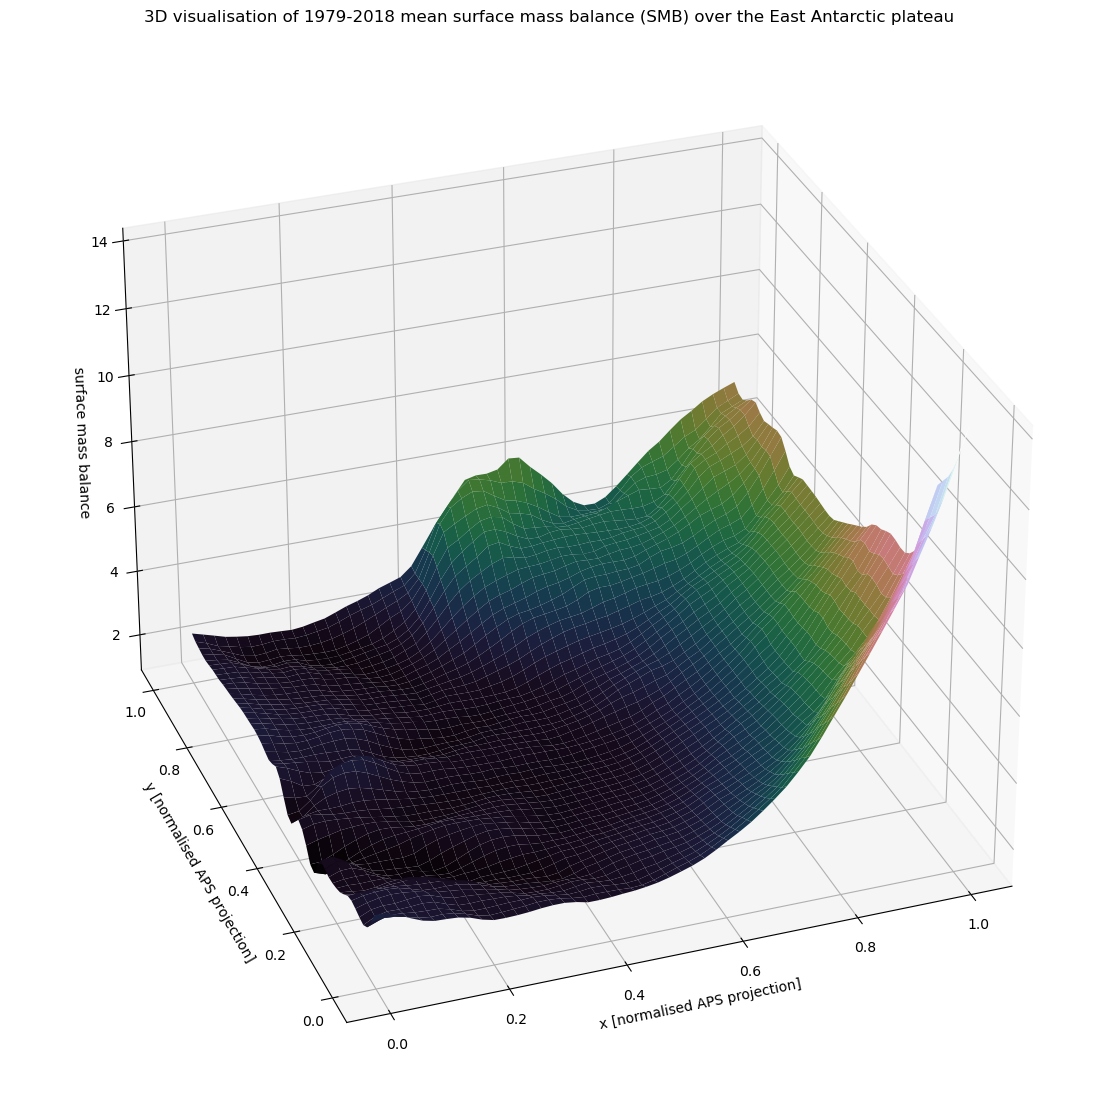

In [16]:
# 3D plot of mean smb
fig = plt.figure(figsize = (14, 14))
ax = plt.axes(projection = '3d') 
# Need to transpose the y-mesh to match
ax.plot_surface(x1_mesh, x2_mesh, y_mesh, rstride = 1, cstride = 1, cmap = 'cubehelix') 

ax.set_title("3D visualisation of 1979-2018 mean surface mass balance (SMB) over the East Antarctic plateau")
ax.set_xlabel('x [normalised APS projection]')
ax.set_ylabel('y [normalised APS projection]')
ax.set_zlabel('surface mass balance')

ax.view_init(elev = 30, azim = 250)

plt.show()

In [1]:
# Export
y_preds.loc.detach().numpy()

# create pandas DataFrame
APS_smb_df = pd.DataFrame(data = {'smb_smooth': y_preds.loc.detach().numpy(),
                          # first column
                          'x1': test_x.detach().numpy()[:,0],
                          # second column
                          'x2': test_x.detach().numpy()[:,1],
                                        }
                                )

NameError: name 'y_preds' is not defined

# Kernels

ToDo: Try non-stationary kernels like Gibbs or `Remes, Sami, Markus Heinonen, and Samuel Kaski. "Non-stationary spectral kernels." Advances in neural information processing systems 30 (2017).`

- [Kernels in GpyTorch](https://docs.gpytorch.ai/en/stable/kernels.html)
    - [GridInterpolationKernel](https://docs.gpytorch.ai/en/stable/kernels.html#gridinterpolationkernel)
    - [SpectralMixtureKernel](https://docs.gpytorch.ai/en/stable/kernels.html#spectralmixturekernel)
- [Kernels in PyMC3](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-covariances.html)

# BO

In [ ]:
# noise-free target function
def target_function(query_locations):
    # takes in list of lists as torch.tensor
    
    # placeholder: empty array
    results = np.empty(0)
    for x in query_locations:
        # Append only mean of kernel (neglect variance) to results array
        # reshape(1, -1): 1 for only one row of x, -1 for remaining dimensions
        # * (-1) because we maximise
        results = np.append(results, (np.array(m.predict(np.array(x).reshape(1,-1))[0]).reshape(-1) * (-1)))
    return(torch.tensor(results))

In [ ]:
def generate_initial_data(n = 10):
    # Need unified dtypes
    train_x = torch.rand(n, 2, dtype = torch.float64) # n rows, 2 columns, sample between 0 and 1 (range)
    exact_obj = target_function(train_x).unsqueeze(-1)
    best_y = exact_obj.max()
    return train_x, exact_obj, best_y

In [ ]:
# function wrapper
def get_next_point(queried_X, queried_y, best_queried_y, bounds, n_points = 1):
    model = SingleTaskGP(queried_X, queried_y)
    # Pass in class liklihood for exact likelihood
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    EI = qExpectedImprovement(model = model, best_f = best_queried_y)
    
    candidates, _ = optimize_acqf(
                                acq_function = EI,
                                bounds = bounds,
                                q = n_points, # number of candidates returned
        
                                # HYPERS
                                num_restarts = 200,
                                raw_samples = 256,
                                options = {"batch_limit" : 5, "maxiter" : 200} 
    )
    return candidates

In [ ]:
# n_runs = 10
#
# Call to generate initial data
# queried_x, queried_y, best_queried_y = generate_initial_data(n = 15)
#
# bounds for inputs: x1 and x2 have been min-max normalised
# bounds = torch.tensor([[0.,0.],[1.,1.]])
#
# for i in range(n_runs):
#    print(f"Run number: {i}")
#    new_candidate = get_next_point(queried_x, queried_y, best_queried_y, bounds, n_points = 1)
#    new_result = target_function(new_candidate).unsqueeze(-1)
#    print(f"New candidate: {new_candidate}")
#    
#    # Update
#    queried_x = torch.cat([queried_x, new_candidate])
#    queried_y = torch.cat([queried_y, new_result])
#    
#    # Check 
#    best_queried_y = queried_y.max()
#    # Maximisation of neg smb to minimise
#    print(f"New best y (smb): {best_queried_y}")

## References

[APA citation style]

- van Dalum, C., van de Berg, W. J., & van den Broeke, M. (2022, May). Antarctic surface climate in RACMO2. 3p3. In EGU General Assembly Conference Abstracts (pp. EGU22-12543).

## Versions

In [ ]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions